# Part 2: Domain Adaptation for Classification of Audio Signals

## 0. Introduction

The [MIMII dataset](https://dcase.community/documents/workshop2019/proceedings/DCASE2019Workshop_Purohit_21.pdf) (Malfunctioning Industrial Machine Investigation and Inspection) is a public dataset of industrial machine sounds created by Hitachi researchers. It contains recordings of four different types of machines — valves, pumps, fans, and slide rails — under both normal and anomalous operating conditions. The anomalies include real-world issues such as leakage, contamination, clogging, rotating unbalance, and rail damage.

The recordings were made in factory environments using a microphone array, with background noise from real factories added to simulate realistic conditions. In total, the dataset provides more than 26,000 normal sound segments and over 6,000 anomalous segments. It has become a benchmark resource for research in acoustic anomaly detection, machine condition monitoring, and domain adaptation, offering a practical way to train and evaluate models that can distinguish between healthy and faulty machine sounds.


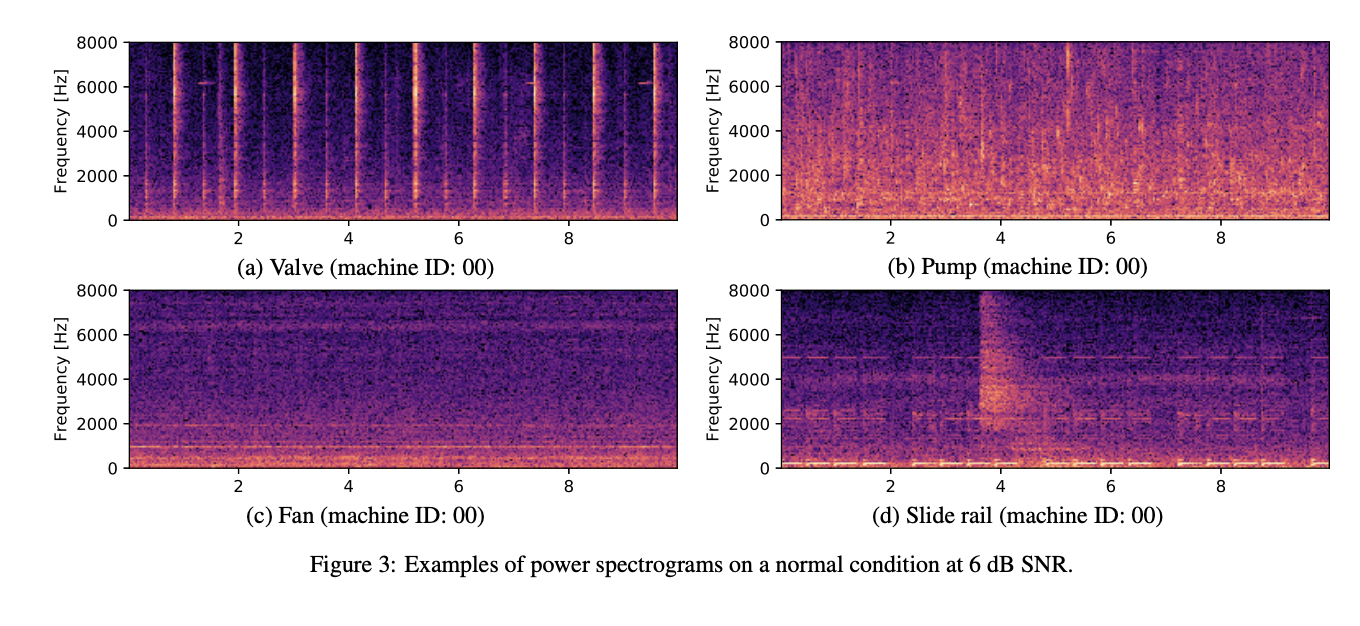

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

from utils import *

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


## 1. Baseline Model

First, we define a CNN model as the baseline model as what we did before.

In [ ]:
from utils.utils_mimi import MIMIIFan_Train, MIMIIFan_Test

# dataLoader
batch_size = 64
Source_data_train = MIMIIFan_Train(root="", machine="../datasets/gearbox", train=True)
Target_data_train = MIMIIFan_Train(root="", machine="../datasets/gearbox", train=False)

Source_data_test = MIMIIFan_Test(root="", machine="../datasets/gearbox", train=True)
Target_data_test = MIMIIFan_Test(root="", machine="../datasets/gearbox", train=False)

dl_source = torch.utils.data.DataLoader(Source_data_train, batch_size, shuffle=True)
dl_target = torch.utils.data.DataLoader(Target_data_train, batch_size, shuffle=True)

dl_test_source = torch.utils.data.DataLoader(Source_data_test, 1)
dl_test_target = torch.utils.data.DataLoader(Target_data_test, 1)


In [ ]:
# define baseline model
class CNN(nn.Module):
    def __init__(self, window, n_mel):
        self.window = window
        self.n_mel = n_mel
        self.n_channels_out = 32
        self.kernel_size = 5

        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=self.kernel_size),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=self.kernel_size),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(16, self.n_channels_out, kernel_size=self.kernel_size),
        )

        self.class_classifier = nn.Sequential(
            nn.Linear(self.n_channels_out * 9 * 1, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        b, h, w = x.shape
        features = self.feature_extractor(x.unsqueeze(1))
        features = features.view(b, -1)

        # Classification head
        class_pred = self.class_classifier(features)
        return class_pred, features


In [ ]:
def test(model, test_loader):
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output, _ = model(data.squeeze(0).to(device))
            correct += torch.argmax(torch.nn.Softmax(dim=1)(output).mean(dim=0)).eq(
                target[0, 0]
            )
        print(
            "Test set:  Accuracy: {}/{} ({:.0f}%)\n".format(
                correct,
                len(test_loader.dataset),
                100.0 * correct / len(test_loader.dataset),
            )
        )


In [ ]:
# Training hyperparameters
learning_rate = 1e-3
epochs_count = 10

# Setup optimizer as usual
model = CNN(n_mel=64, window=32).to(device)
optimizer = optim.SGD(model.parameters(), learning_rate, weight_decay=0.01,momentum=0.9)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()


In [ ]:
training_loss = 0
for epoch_idx in range(epochs_count):
    model.train()
    print(f"Epoch {epoch_idx+1:04d} / {epochs_count:04d}", end="\n=================\n")
    dl_source_iter = iter(dl_source)

    for batch_idx in tqdm(range(len(dl_source))):
        optimizer.zero_grad()
        # Train on source domain
        X_s, y_s = next(dl_source_iter)

        class_pred, _ = model(X_s.to(device))

        loss = loss_fn_class(class_pred, y_s.long().to(device))
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(
        f"[{epoch_idx+1}/{epochs_count}] "
        f"class_loss: {training_loss/len(dl_source):.4f} "
    )
    training_loss = 0
    model.eval()
    print("Source Accuracy")
    test(model, dl_test_source)
    print("Target Accuracy")
    test(model, dl_test_target)
